In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()

X_train.shape,y_train.shape,X_test.shape,y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

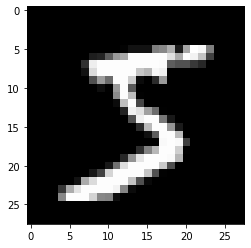

In [3]:
plt.imshow(X_train[0],cmap='gray')

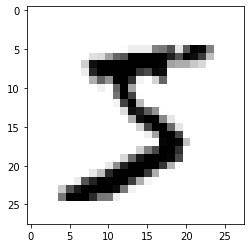

In [4]:
plt.imshow(X_train[0],cmap='gray_r')

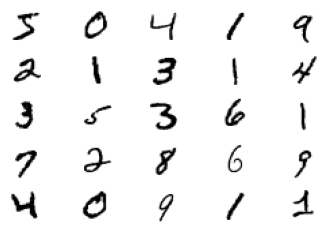

In [5]:
for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(X_train[i],cmap='gray_r')
plt.show()

In [6]:
#discriminator
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=(28,28,1)),
    tf.keras.layers.LeakyReLU(alpha=.2),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),padding='same'),
    tf.keras.layers.LeakyReLU(alpha=.2),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

opt=tf.keras.optimizers.Adam(lr=.0002,beta_1=.5)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [7]:
X_train_=np.expand_dims(X_train,axis=-1)   #add channels dimensions
X_train_.shape   #scale from [0,255] to [0,1]

(60000, 28, 28, 1)

In [8]:
X_train_=X_train_.astype('float32')/255

In [9]:
def generate_real_samples(dataset,n_samples):
    ix=np.random.randint(0,dataset.shape[0],n_samples)   #choose random instances
    x=dataset[ix]                                        #retrieve selected images
    y=np.ones((n_samples,1))                             #generate 'real' class labels(1)
    return x,y

def generate_fake_samples(n_samples):
    x=np.random.rand(28*28*n_samples)   #generate uniform random numbers in[0,1]
    x=x.reshape((n_samples,28,28,1))    #reshape into a batch of grayscale images
    y=np.zeros((n_samples,1))           #generate 'fake' class label(0)
    return x,y

In [10]:
def train_discriminator(model,dataset,n_iter=100,n_batch=256):
    half_batch=int(n_batch/2)
    for i in range(n_iter):                                        #manually enumerate epochs
        x_real,y_real=generate_real_samples(dataset,half_batch)    #get randomly selected 'real' samples
        _,real_acc=model.train_on_batch(x_real,y_real)             #update discriminator on real samples
        x_fake,y_fake=generate_fake_samples(half_batch)            #generate 'fake' samples
        _,fake_acc=model.train_on_batch(x_fake,y_fake)             #update discriminator on fake samples
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1,real_acc*100,fake_acc*100))

train_discriminator(model,X_train_)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

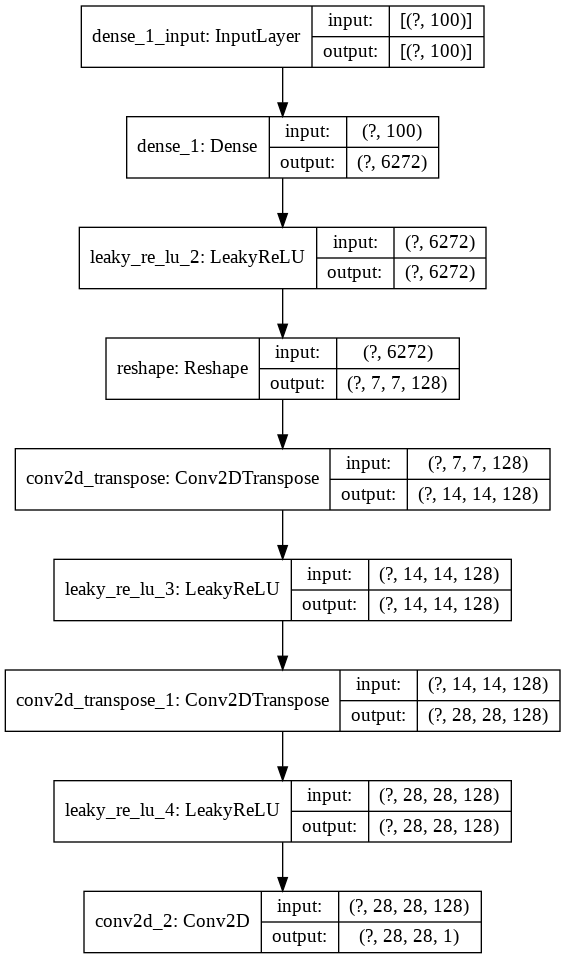

In [11]:
n_nodes=128*7*7

#generator
model1=tf.keras.Sequential([
    tf.keras.layers.Dense(n_nodes,input_dim=100),
    tf.keras.layers.LeakyReLU(alpha=.2),
    tf.keras.layers.Reshape((7,7,128)),
    tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(4,4),strides=(2,2),padding='same'),
    tf.keras.layers.LeakyReLU(alpha=.2),
    tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(4,4),strides=(2,2),padding='same'),
    tf.keras.layers.LeakyReLU(alpha=.2),
    tf.keras.layers.Conv2D(filters=1,kernel_size=(7,7),activation='sigmoid',padding='same'),
])

model1.summary()

tf.keras.utils.plot_model(model1,show_shapes=True,show_layer_names=True)

In [12]:
def generate_latent_points(latent_dim,n_samples):     #generate points in latent space as input for the generator
    x_input=np.random.randn(latent_dim*n_samples)     #generate points in the latent space
    x_input=x_input.reshape(n_samples,latent_dim)     #reshape into a batch of inputs for the network
    return x_input

def generate_fake_samples(g_model,latent_dim,n_samples):    #use the generator to generate n fake examples, with class labels
    x_input=generate_latent_points(latent_dim,n_samples)    #generate points in latent space
    x=g_model.predict(x_input)                              #predict outputs
    y=np.zeros((n_samples,1))                               #create 'fake' class labels(0)
    return x,y

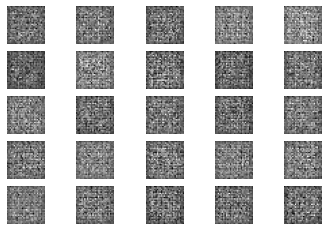

In [13]:
x,_=generate_fake_samples(model1,100,25)

for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(x[i,:,:,0],cmap='gray_r')
plt.show()

In [14]:
def define_gan(g_model,d_model):       #define the combined generator and discriminator model, for updating the generator
    d_model.trainable=False            #make weights in the discriminator not trainable
    model=tf.keras.Sequential()        #connect them
    model.add(g_model)                 #add generator
    model.add(d_model)                 #add discriminator
    opt=tf.keras.optimizers.Adam(lr=.0002,beta_1=.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


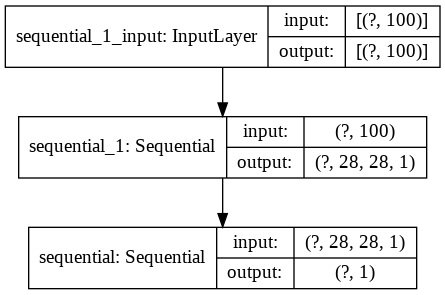

In [15]:
d_model=model
g_model=model1
gan_model=define_gan(g_model,d_model)
gan_model.summary()
tf.keras.utils.plot_model(gan_model,show_shapes=True,show_layer_names=True)

In [ ]:
'''
def train_gan(gan_model,latent_dim,n_epochs=100,n_batch=256):#train the composite model
    for i in range(n_epochs):
        x_gan=generate_latent_points(latent_dim,n_batch)     #prepare points in latent space as input for the generator
        y_gan=np.ones((n_batch,1))                           #create inverted labels for the fake samples
        gan_model.train_on_batch(x_gan,y_gan)                #update the generator via the discriminator's error
'''

"\ndef train_gan(gan_model,latent_dim,n_epochs=100,n_batch=256):#train the composite model\n    for i in range(n_epochs):\n        x_gan=generate_latent_points(latent_dim,n_batch)     #prepare points in latent space as input for the generator\n        y_gan=np.ones((n_batch,1))                           #create inverted labels for the fake samples\n        gan_model.train_on_batch(x_gan,y_gan)                #update the generator via the discriminator's error\n"

In [16]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=100,n_batch=256):#train the generator and discriminator
    batch_per_epoch=int(dataset.shape[0]/n_batch)
    half_batch=int(n_batch/2)
    for i in range(n_epochs):                                                    #enumerate epochs
        for j in range(batch_per_epoch):                                         #enumerate batches over the training set
            x_real,y_real=generate_real_samples(dataset,half_batch)              #get random real samples
            x_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch)   #generate fake samples
            x,y=np.vstack((x_real,x_fake)),np.vstack((y_real,y_fake))               #create training set for the discriminator
            d_loss,_=d_model.train_on_batch(x,y)                                 #update discriminator model weights
            x_gan=generate_latent_points(latent_dim,n_batch)                     #prepare points in latent space as input for the generator
            y_gan=np.ones((n_batch,1))                                           #create inverted labels for the fake samples
            g_loss=gan_model.train_on_batch(x_gan,y_gan)                         #update generator via discriminator's error
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss, g_loss))
        if (i+1)%10==0:                                                          #evaluate model performance per 10 times
            summarize_performance(i,g_model,d_model,dataset,latent_dim)

In [17]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=100):#evaluate the discriminator, plot generated images, save generator model
    x_real,y_real=generate_real_samples(dataset,n_samples)
    _,acc_real=d_model.evaluate(x_real,y_real,verbose=0)     #evaluate discriminator on real examples
    x_fake,y_fake=generate_fake_samples(g_model,latent_dim,n_samples)
    _,acc_fake=d_model.evaluate(x_fake,y_fake,verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100,acc_fake*100))
    save_plot(x_fake,epoch)
    filename='generator_model_%03d.h5' % (epoch+1)           #save the generator model title file
    g_model.save(filename)

In [18]:
def save_plot(examples,epoch,n=10):        #create and save a plot of generated images (reversed grayscale)
    for i in range(n*n):
        plt.subplot(n,n,1+i)
        plt.axis('off')
        plt.imshow(examples[i,:,:,0],cmap='gray_r')
    filename='generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [19]:
train(g_model,d_model,gan_model,X_train_,100)

Streaming output truncated to the last 5000 lines.
>79, 153/234, d=0.692, g=0.725
>79, 154/234, d=0.694, g=0.721
>79, 155/234, d=0.687, g=0.711
>79, 156/234, d=0.695, g=0.704
>79, 157/234, d=0.693, g=0.681
>79, 158/234, d=0.692, g=0.695
>79, 159/234, d=0.685, g=0.705
>79, 160/234, d=0.692, g=0.709
>79, 161/234, d=0.691, g=0.694
>79, 162/234, d=0.689, g=0.692
>79, 163/234, d=0.682, g=0.706
>79, 164/234, d=0.693, g=0.724
>79, 165/234, d=0.693, g=0.730
>79, 166/234, d=0.691, g=0.710
>79, 167/234, d=0.687, g=0.685
>79, 168/234, d=0.690, g=0.689
>79, 169/234, d=0.685, g=0.697
>79, 170/234, d=0.694, g=0.694
>79, 171/234, d=0.693, g=0.689
>79, 172/234, d=0.694, g=0.699
>79, 173/234, d=0.681, g=0.687
>79, 174/234, d=0.705, g=0.729
>79, 175/234, d=0.692, g=0.732
>79, 176/234, d=0.701, g=0.716
>79, 177/234, d=0.687, g=0.680
>79, 178/234, d=0.692, g=0.670
>79, 179/234, d=0.690, g=0.680
>79, 180/234, d=0.692, g=0.705
>79, 181/234, d=0.693, g=0.739
>79, 182/234, d=0.693, g=0.726
>79, 183/234, d=0.6

In [ ]:
#g_model.save('generator_model.h5')

## Generate Image

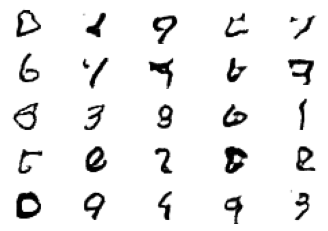

In [21]:
load=tf.keras.models.load_model('generator_model_100.h5',compile=False)
latent_points=generate_latent_points(100,25)
x=load.predict(latent_points)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(x[i,:,:,0],cmap='gray_r')
plt.show()

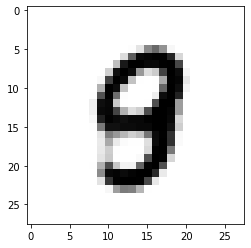

In [23]:
vector=np.asarray([[0.0 for _ in range(100)]])
x=load.predict(vector)
plt.imshow(x[0,:,:,0],cmap='gray_r')
plt.show()